<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
    !pip install git+https://github.com/VLL-HD/FrEIA.git

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logging.info("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


2021-06-27 18:04:12,114:INFO:Using device: cpu


/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Data

In [3]:
from sklearn.datasets import make_moons

n_train = 1_000
data, label = make_moons(n_samples=n_train, noise=0.05)

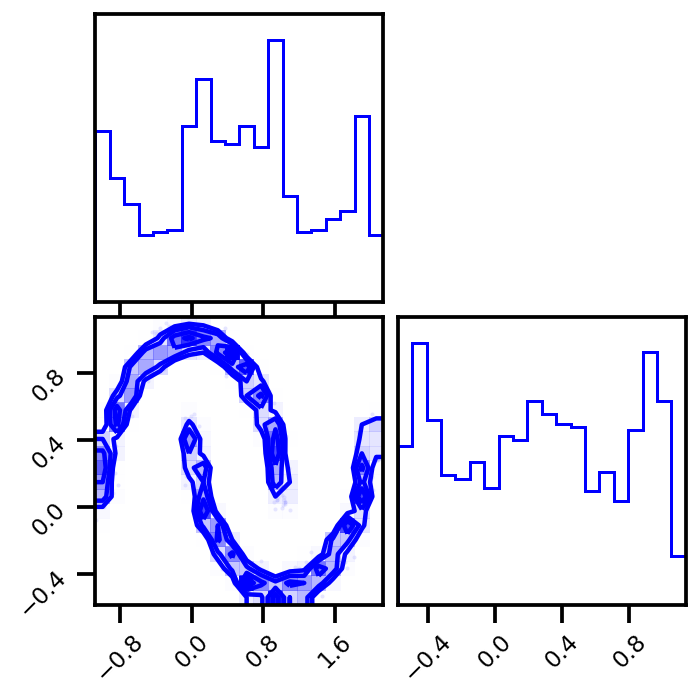

In [4]:
fig = corner.corner(data, hist_factor=2, color="blue")

#### DataLoader

In [5]:
n_train = 5_000
n_valid = 1_000
data_train, label = make_moons(n_samples=n_train, noise=0.05, random_state=123)
data_valid, label = make_moons(n_samples=n_valid, noise=0.05, random_state=42)
X_train = torch.FloatTensor(data_train)
X_valid = torch.FloatTensor(data_valid)

# make into dataset
train_ds = TensorDataset(X_train)
valid_ds = TensorDataset(X_valid)

# make dataloader
batch_size = 256
num_workers = 8
shuffle = True

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## Model

### Lightning Module

In [6]:
from src.lit_plane import FlowLearnerPlane

In [7]:
import ml_collections

cfg = ml_collections.ConfigDict()
cfg.num_epochs = 150
cfg.learning_rate = 1e-2


### Standard RVP

In [8]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

N_DIM = 2

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM)
for k in range(8):
    inn.append(
        Fm.AllInOneBlock, 
        subnet_constructor=subnet_fc, 
        permute_soft=True, 
        gin_block=False, 
        learned_householder_permutation=0
        )

base_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

#### Initial Transformation

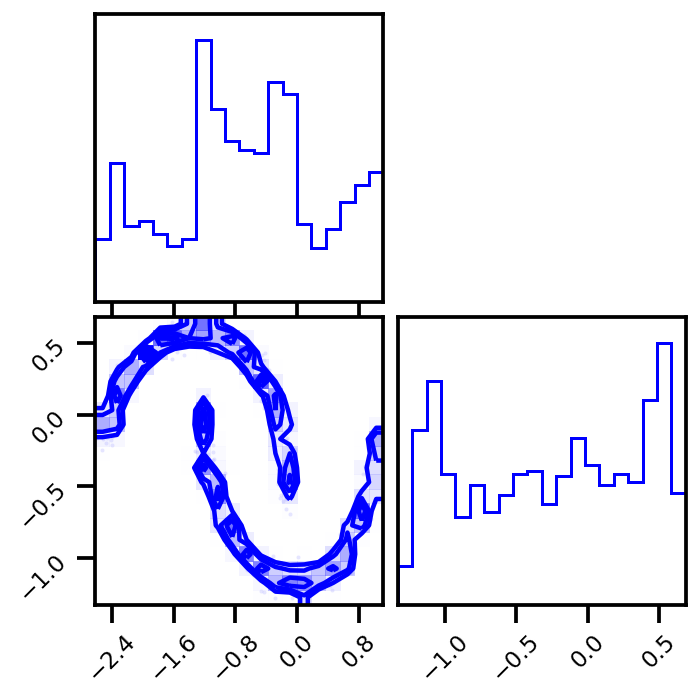

In [9]:
x = torch.Tensor(data)
z, log_jac_det = inn(x)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="blue")

## Training

In [156]:
learn = FlowLearnerPlane(inn, cfg, base_dist)
trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus=0,
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm'
)
trainer.fit(learn, train_dataloader=train_dl, val_dataloaders=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 16.5 K
--------------------------------------
16.4 K    Trainable params
64        Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

#### Latent Space

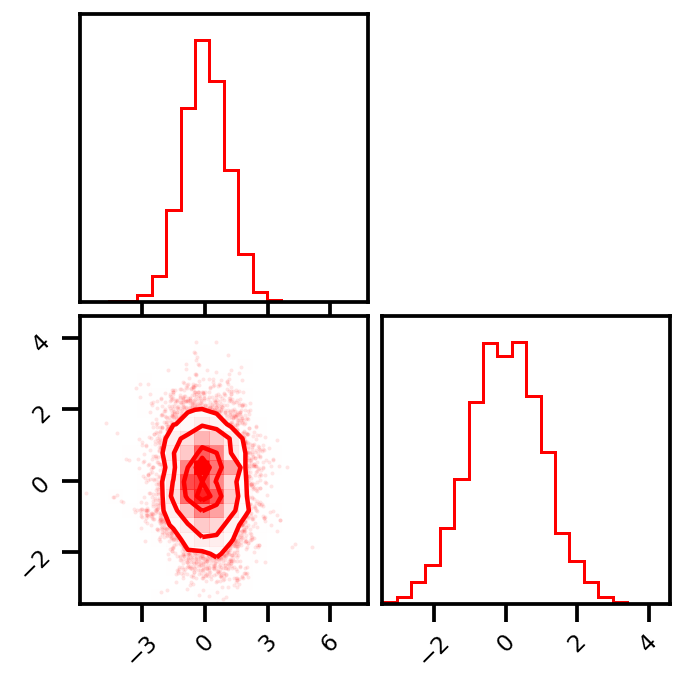

In [157]:
n_test = 10_000
data_test, label = make_moons(n_samples=n_test, noise=0.05)
x = torch.Tensor(data_test)
z, log_jac_det = learn.model(x)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="red")

#### Inverse Transform

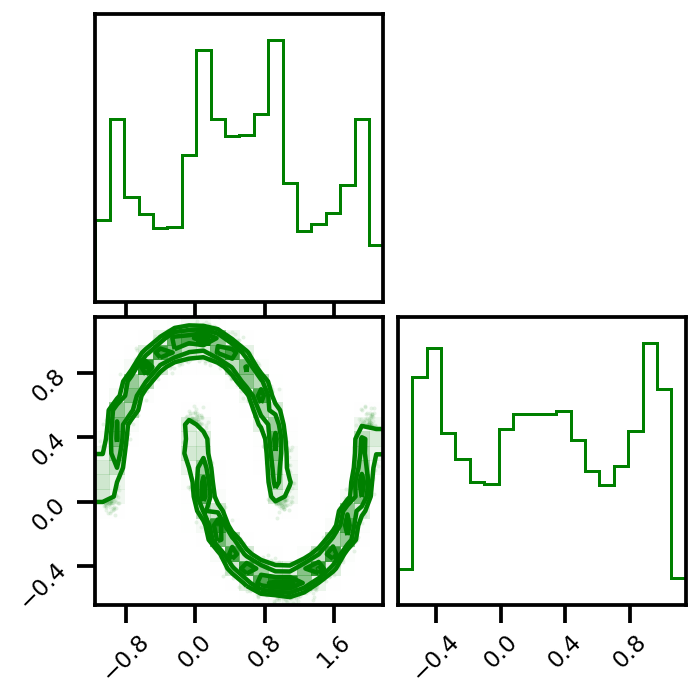

In [158]:
x_ori, _ = learn.model(z, rev=True)

fig = corner.corner(x_ori.detach().numpy(), hist_factor=2, color="green")

#### Density Estimation

In [160]:
from src.viz.bivariate import generate_2d_grid

# Read data
X_plot, _ = make_moons(n_samples=100_000, shuffle=True, noise=0.05, random_state=123 + 2)

# # sampled data
data_plot, label = make_moons(n_samples=100, noise=0.05)
xyinput = generate_2d_grid(data_plot, 500, buffer=0.1)

In [161]:
z, log_jac_det = learn.model(torch.Tensor(xyinput))

X_log_prob = base_dist.log_prob(z).sum(1) + log_jac_det
X_log_prob = X_log_prob.detach().numpy()

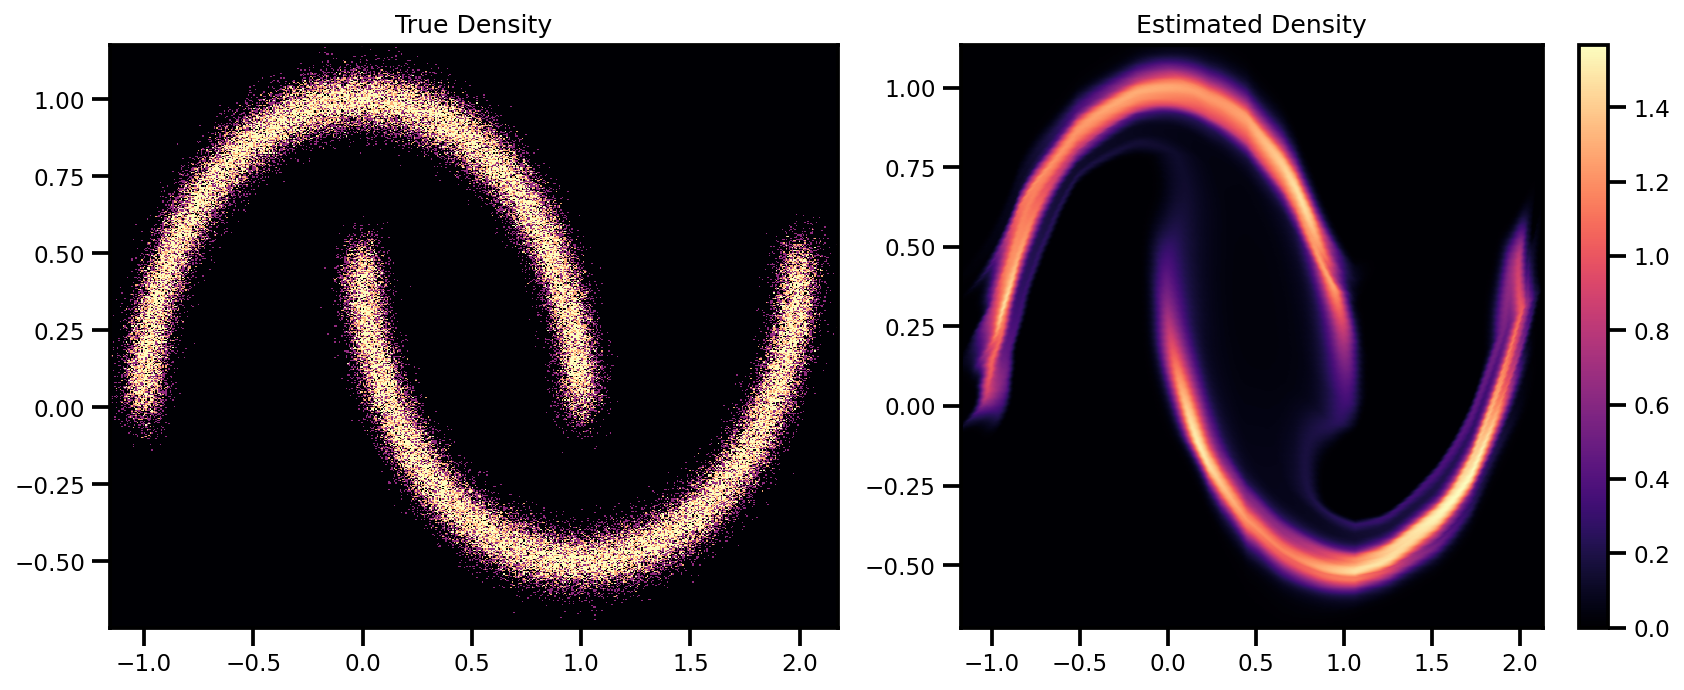

In [162]:
from matplotlib import cm

# # Original Density
# n_samples = 1_000_000
# n_features = 2
# X_plot = load_data(n_samples, 42)
# X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = np.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"
# cmap = "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)


h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, #vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

#### Sampling

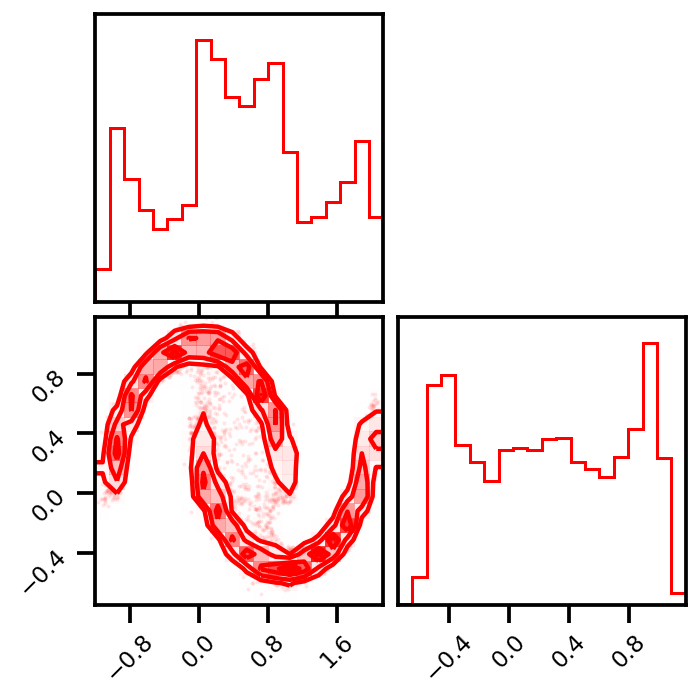

In [159]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, N_DIM)
samples, _ = learn.model(z, rev=True)

fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")

## Custom Layer

In [56]:
import ml_collections

cfg = ml_collections.ConfigDict()
cfg.loss_fn = "inn"
cfg.num_epochs = 150
cfg.learning_rate = 1e-2
cfg.batch_size = 100
cfg.weight_decay = 0.0
cfg.beta1 = 0.9
cfg.beta2 = 0.999
cfg.betas = (cfg.beta1, cfg.beta2)

#### Mixture CDF Flows

In [93]:
def tensor2numpy(x):
    return x.detach().cpu().numpy()
def numpy2tensor(x):
    return torch.Tensor(x)

In [132]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

from src.models.layers.rqs import RQSplines
from src.models.layers.mixture import GaussianMixtureCDF
from src.models.layers.mixture_log import LogisticMixtureCDF
from src.models.layers.nonlinear import InverseGaussCDF, Logit

n_features = 2
inn = Ff.SequenceINN(n_features)

init_X = [[numpy2tensor(data)], None]

for k in range(8):

    inn.append(
        GaussianMixtureCDF, 
        n_components=8, 
        init_X=tensor2numpy(init_X[0][0])
    )
    # forward transformation
    with torch.no_grad():
        init_X = inn.module_list[-1](x=init_X[0])
    inn.append(
        InverseGaussCDF
    )
    with torch.no_grad():
        init_X = inn.module_list[-1](x=init_X[0])

    inn.append(Fm.HouseholderPerm, n_reflections=4)
    with torch.no_grad():
        init_X = inn.module_list[-1](x=init_X[0])


base_dist = dist.Normal(torch.zeros(2), torch.ones(2))

In [133]:
x = torch.Tensor(data)
z, log_jac_det = inn(x[:1000])

z.min(), z.max(), z.shape, log_jac_det.shape,log_jac_det.min(), log_jac_det.max(), 

(tensor(-2.9979, grad_fn=<MinBackward1>),
 tensor(2.9761, grad_fn=<MaxBackward1>),
 torch.Size([1000, 2]),
 torch.Size([1000]),
 tensor(-3.8581, grad_fn=<MinBackward1>),
 tensor(14.0008, grad_fn=<MaxBackward1>))

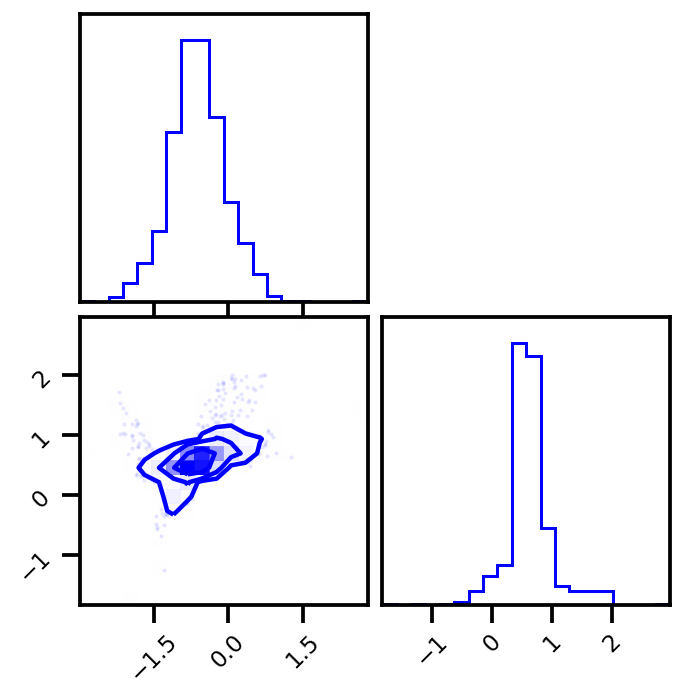

In [134]:

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="blue")

In [135]:
%%time

with torch.no_grad():
    x_ori, log_jac_det = inn(z, rev=True)

x_ori.min(), x_ori.max(), x_ori.shape, log_jac_det.shape,log_jac_det.min(), log_jac_det.max(), 

CPU times: user 2.3 s, sys: 91.1 ms, total: 2.39 s
Wall time: 288 ms


(tensor(-1.0778),
 tensor(2.1460),
 torch.Size([1000, 2]),
 torch.Size([1000, 2]),
 tensor(-27.6070),
 tensor(1.5351))

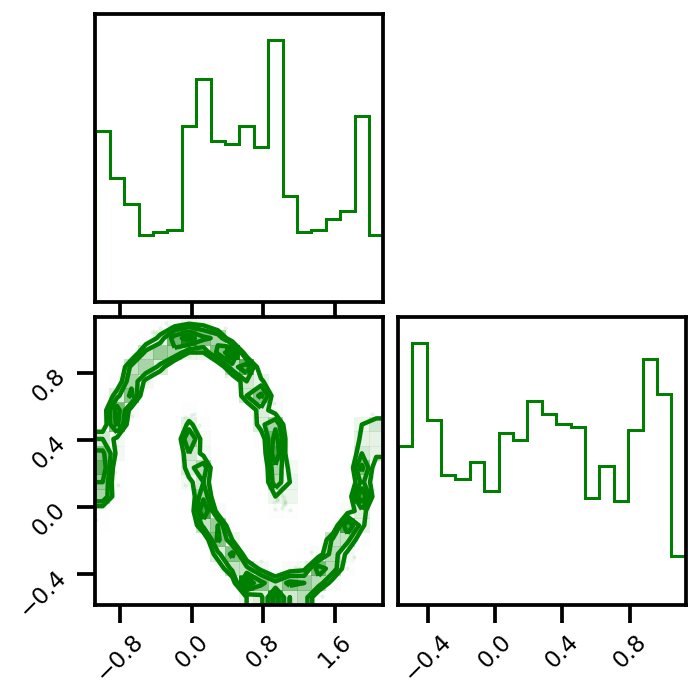

In [136]:
fig = corner.corner(x_ori.detach().numpy(), hist_factor=2, color="green")

In [137]:
learn = FlowLearnerPlane(inn, base_dist, cfg)
trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus=0,
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm'
)
trainer.fit(learn, train_dataloader=train_dl, val_dataloaders=None)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 448   
--------------------------------------
448       Trainable params
0         Non-trainable params
448       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

#### Latent Domain

In [138]:
n_test = 10_000
data_test, label = make_moons(n_samples=n_test, noise=0.05)
x = torch.Tensor(data_test)


CPU times: user 4.4 s, sys: 85.1 ms, total: 4.49 s
Wall time: 284 ms


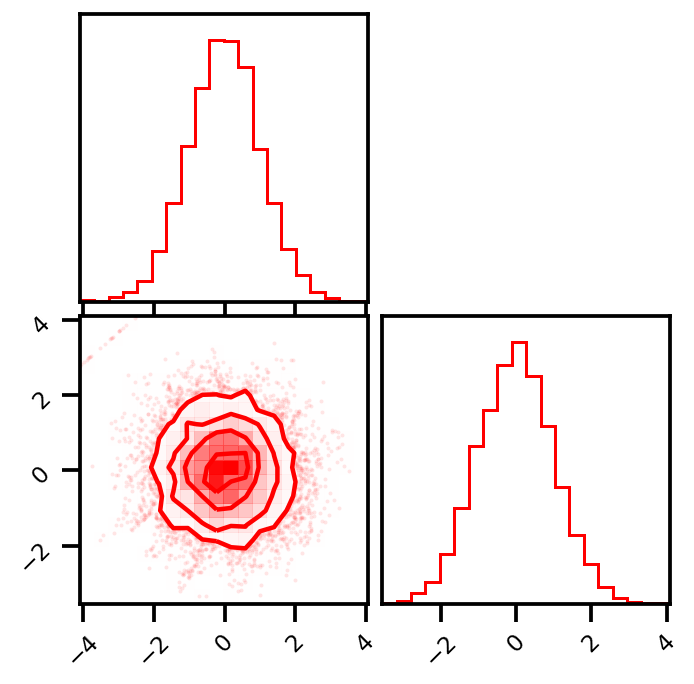

In [139]:
%%time
z, log_jac_det = learn.model(x)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="red")

#### Inverse Transform

CPU times: user 20.1 s, sys: 117 ms, total: 20.2 s
Wall time: 843 ms


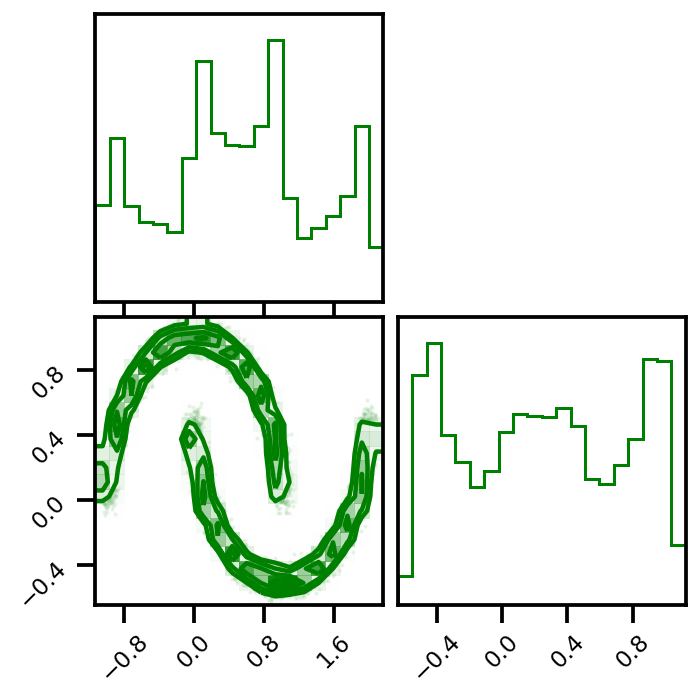

In [140]:
%%time

x_ori, _ = inn(z,rev=True)

fig = corner.corner(x_ori.detach().numpy(), hist_factor=2, color="green")

#### Sampling

In [141]:
%%time
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 10_000
z = torch.randn(n_samples, N_DIM)
samples, _ = learn.model(z, rev=True)


CPU times: user 20.1 s, sys: 95.3 ms, total: 20.2 s
Wall time: 761 ms


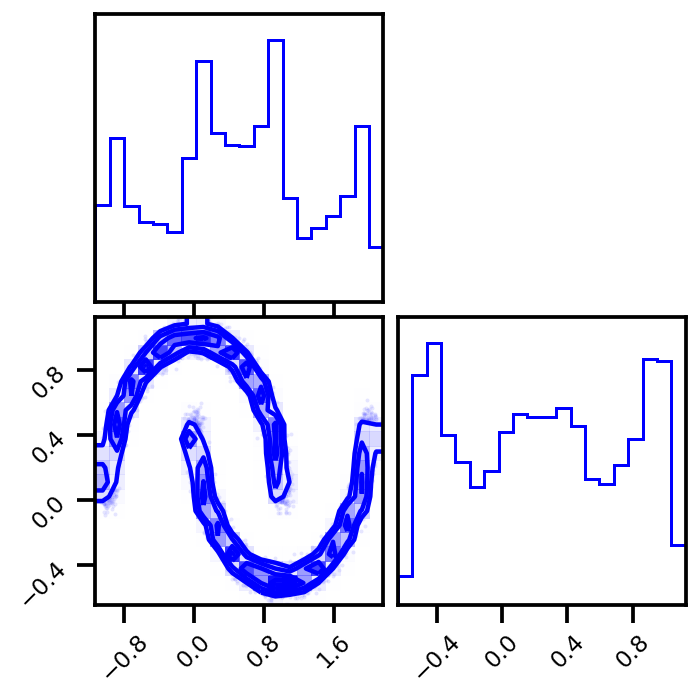

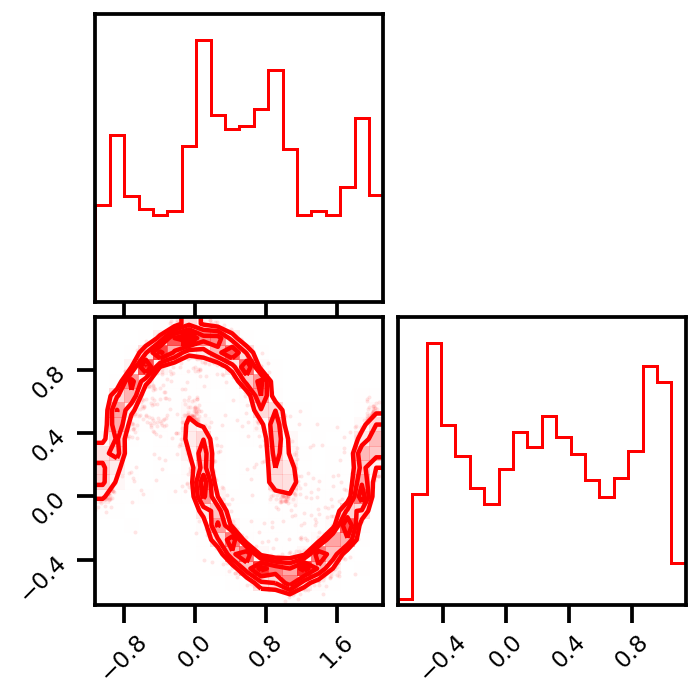

In [142]:

fig = corner.corner(data_test, hist_factor=2, color="blue")
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")

#### Density Estimation

In [143]:
from src.viz.bivariate import generate_2d_grid

In [144]:
# Read data
X_plot, _ = make_moons(n_samples=100_000, shuffle=True, noise=0.05, random_state=123 + 2)

# # sampled data
data_plot, label = make_moons(n_samples=100, noise=0.05)
xyinput = generate_2d_grid(data_plot, 500, buffer=0.1)

In [145]:
z, log_jac_det = inn(torch.Tensor(xyinput))

X_log_prob = base_dist.log_prob(z).sum(1) + log_jac_det
X_log_prob = X_log_prob.detach().numpy()

In [146]:
X_log_prob.shape

(250000,)

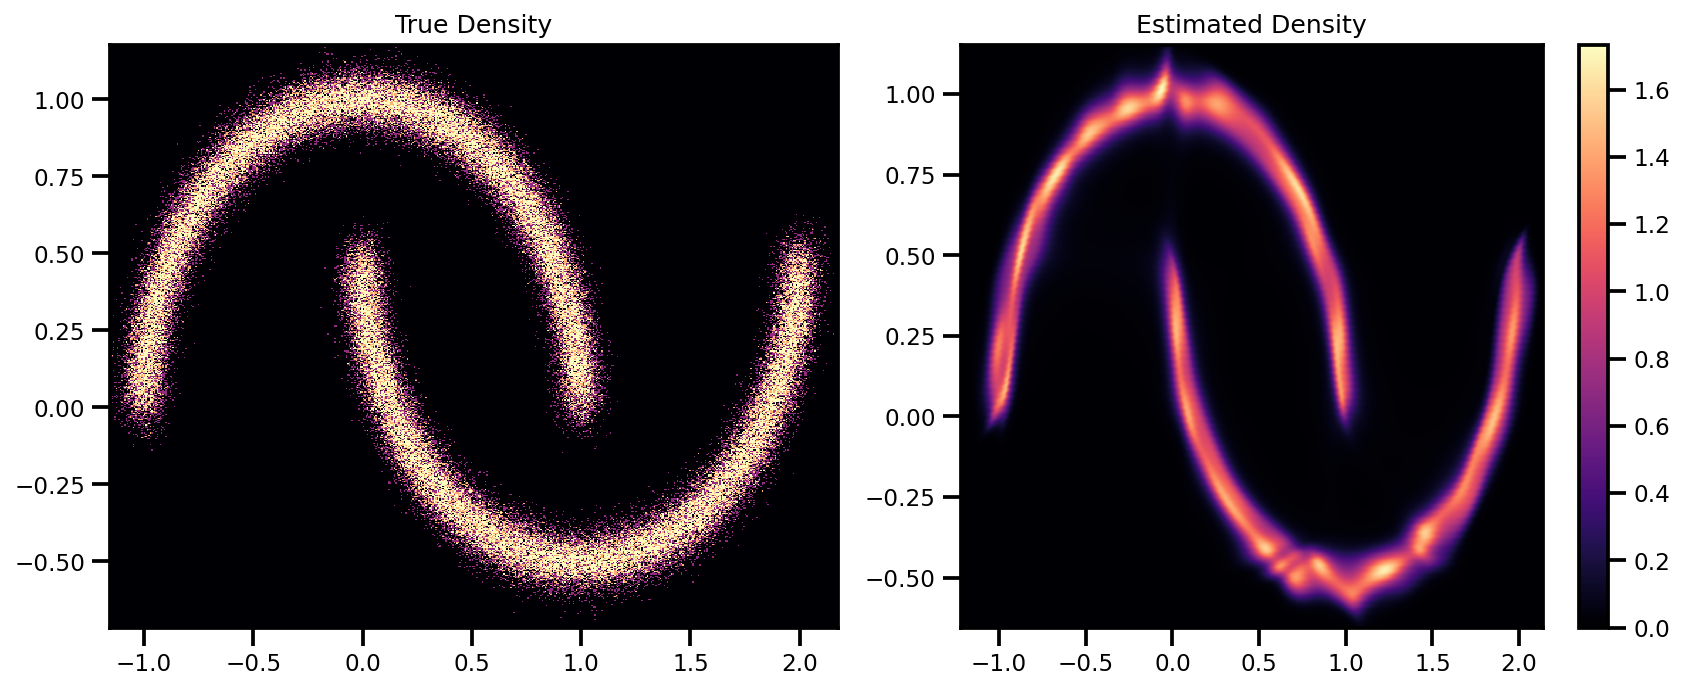

In [147]:
from matplotlib import cm

# # Original Density
# n_samples = 1_000_000
# n_features = 2
# X_plot = load_data(n_samples, 42)
# X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = np.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"
# cmap = "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)


h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, #vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()